<a href="https://colab.research.google.com/github/young-hwanlee/my-practical-statistics-for-data-scientists/blob/main/Chapter_6_Statistical_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Clone the repository
# !git clone https://github.com/young-hwanlee/practical-statistics-for-data-scientists.git

# # Open the file from the list of contents (File)
# # Then, copy and paste it

## Practical Statistics for Data Scientists (Python)
## Chapter 6. Statistical Machine Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [2]:
!pip install dmba

     |████████████████████████████████| 11.8 MB 5.2 MB/s 


In [3]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
print()

no display found. Using non-interactive Agg backend



In [4]:
# try:
#     import common
#     DATA = common.dataDirectory()
# except ImportError:
#     DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [5]:
# LOAN200_CSV = DATA / 'loan200.csv'
# LOAN3000_CSV = DATA / 'loan3000.csv'
# LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

DATA = 'https://raw.githubusercontent.com/young-hwanlee/practical-statistics-for-data-scientists/master/data/'

LOAN200_CSV = DATA + 'loan200.csv'
LOAN3000_CSV = DATA + 'loan3000.csv'
LOAN_DATA_CSV = DATA + 'loan_data.csv.gz'

Set this if the notebook crashes in the XGBoost part.


In [6]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

## **6.1 K-Nearest Neighbors**
### **6.1.1 A Small Example: Predicting Loan Default**

In [7]:
loan200 = pd.read_csv(LOAN200_CSV)
 
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


In [8]:
X.head()

,payment_inc_ratio,dti
1,5.46933,21.33
2,6.90294,8.97
3,11.14800,1.83
4,3.72120,10.81
5,1.89923,11.34


In [9]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

nbrs    # return (neigh_dist, neigh_ind)

(array([[0.43787986, 0.88189485, 0.91751052, 1.65569826, 1.70611292,
         1.90596261, 2.08135622, 2.41682933, 2.44351029, 2.73230786,
         2.74245402, 2.86057968, 2.88767355, 2.99889915, 3.19912226,
         3.21420799, 3.36546794, 3.37976028, 3.462634  , 3.5414263 ]]),
 array([[ 34, 181, 180,  84,   8, 168,  20, 198,  76,  54, 140,  30,  65,
         162, 160, 111,  77,  45,  40, 138]]))

In [10]:
nbrs[0]

array([[0.43787986, 0.88189485, 0.91751052, 1.65569826, 1.70611292,
        1.90596261, 2.08135622, 2.41682933, 2.44351029, 2.73230786,
        2.74245402, 2.86057968, 2.88767355, 2.99889915, 3.19912226,
        3.21420799, 3.36546794, 3.37976028, 3.462634  , 3.5414263 ]])

In [11]:
nbrs[0][0]

array([0.43787986, 0.88189485, 0.91751052, 1.65569826, 1.70611292,
       1.90596261, 2.08135622, 2.41682933, 2.44351029, 2.73230786,
       2.74245402, 2.86057968, 2.88767355, 2.99889915, 3.19912226,
       3.21420799, 3.36546794, 3.37976028, 3.462634  , 3.5414263 ])

In [12]:
maxDistance

3.541426301647403

In [13]:
loan200

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81
...,...,...,...
196,default,11.66300,26.09
197,default,2.97641,16.41
198,default,1.96846,19.98
199,paid off,9.64200,20.17


In [14]:
print(nbrs[1][0])
print(nbrs[1][0] + 1)

[ 34 181 180  84   8 168  20 198  76  54 140  30  65 162 160 111  77  45
  40 138]
[ 35 182 181  85   9 169  21 199  77  55 141  31  66 163 161 112  78  46
  41 139]


In [15]:
loan200.loc[nbrs[1][0] + 1,:]

,outcome,payment_inc_ratio,dti
35,default,8.65527,22.23
182,default,9.05778,21.62
181,paid off,9.44925,23.30
85,default,8.70942,24.13
9,default,9.43396,24.15
169,default,8.02887,20.86
21,default,6.91886,22.47
199,paid off,9.64200,20.17
77,paid off,7.70160,24.57
55,paid off,11.52250,21.45


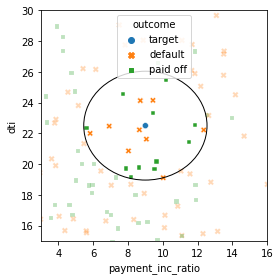

In [16]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1, :]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

### **6.1.4 Standardization (Normalization, Z-Scores)**

In [17]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [18]:
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data.head()

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [19]:
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
loan_data.head()

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [20]:
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
print()

X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
nbrs    # return (neigh_dist, neigh_ind)

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4



(array([[1.55563118, 5.64040694, 7.13883816, 8.84224262, 8.97277387]]),
 array([[35535, 33650, 25862, 42952, 43598]]))

In [21]:
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [22]:
print(X.loc[nbrs[1][0] + 1, :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [23]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()

scaler.fit(X)
X_std = scaler.transform(X)
newloan_std = scaler.transform(newloan)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


In [24]:
scaler.fit(X * 1.0)
X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


### **6.1.6 KNN as a Feature Engineering**

In [26]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

In [34]:
print(knn.predict_proba(X))
print(np.shape(knn.predict_proba(X)))
print()
X

[[0.35 0.65]
 [0.2  0.8 ]
 [0.4  0.6 ]
 ...
 [0.45 0.55]
 [0.35 0.65]
 [0.5  0.5 ]]
(45342, 2)



,dti,revol_bal,revol_util,open_acc,delinq_2yrs_zero,pub_rec_zero
0,1.00,1687,9.4,3,1,1
1,5.55,5210,32.6,11,1,1
2,18.08,9279,36.5,2,1,1
3,10.08,10452,91.7,4,1,1
4,7.06,11997,55.5,14,1,1
...,...,...,...,...,...,...
45337,18.97,9725,58.2,9,1,0
45338,13.24,4925,40.7,13,0,1
45339,7.95,6574,73.0,8,1,1
45340,26.91,10303,32.4,10,1,1


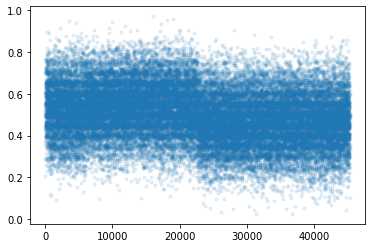

In [37]:
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')

In [42]:
print(knn.predict_proba(X)[:, 0])
print('mean:', np.mean(knn.predict_proba(X)[:, 0]))
print('std:', np.std(knn.predict_proba(X)[:, 0]))
print('min:', np.min(knn.predict_proba(X)[:, 0]))
print('max:', np.max(knn.predict_proba(X)[:, 0]))

[0.35 0.2  0.4  ... 0.45 0.35 0.5 ]
mean: 0.5010983194389308
std: 0.128734223078781
min: 0.0
max: 0.95


In [38]:
loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

count    45342.000000
mean         0.501098
std          0.128736
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


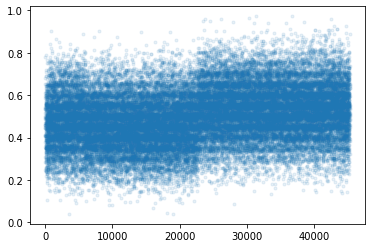

In [43]:
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,1]], 
            alpha=0.1, marker='.')

## **6.2 Tree Models**
### **6.2.1 A Simple Example**
The package _scikit-learn_ has the class `DecisionTreeClassifier` to build a decision tree model. The function `plotDecisionTree` from the _dmba_ package can be used to visualize the tree.

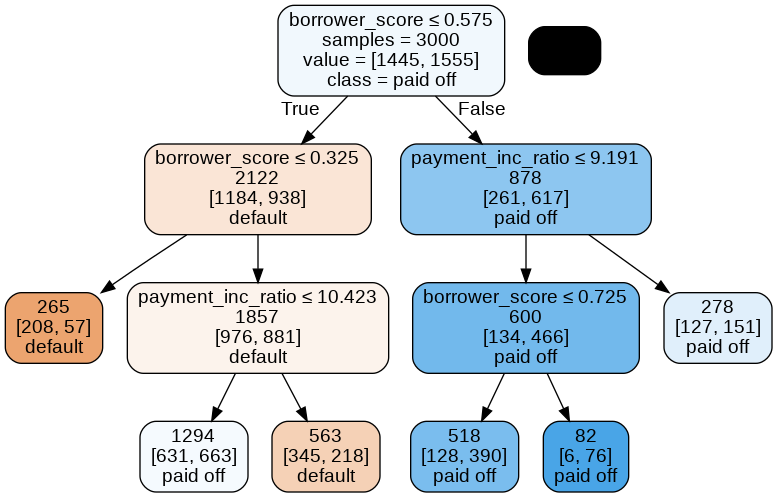

In [45]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors,
                 class_names=loan_tree.classes_)

In [46]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


### **6.2.2 The Recursive Partitioning Algorithm**

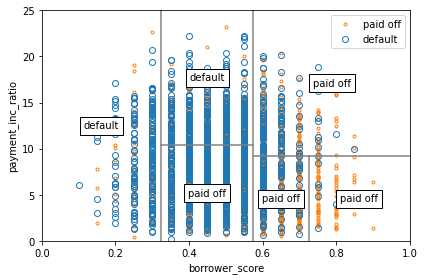

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)

ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725

ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

### **6.2.3 Measuring Homogeneity or Impurity**

In [51]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

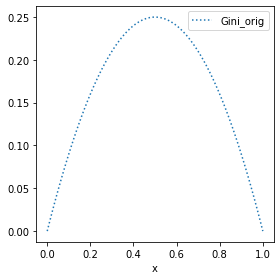

In [59]:
x = np.linspace(0, 1.0, 100)

impure = pd.DataFrame({
    'x': x,
    'Gini_orig': [giniFunction(xi) for xi in x]
})

fig, ax = plt.subplots(figsize=(4, 4))
impure.plot(x='x', y='Gini_orig', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

In [55]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

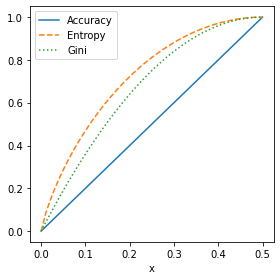

In [56]:
fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

## **6.3 Bagging and the Random Forest**
### **6.3.2 Random Forest**

In [ ]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

In [ ]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

In [ ]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')

In [ ]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

### **6.3.3 Variable importance**
This is different to R. The accuracy decrease is not available out of the box.

In [ ]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                        criterion='entropy')
print(rf_all_entropy.fit(X, y))

In [ ]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

In [ ]:
importances = rf_all.feature_importances_

df = pd.DataFrame({
    'feature': X.columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in 
                         X.columns],
    'Gini decrease': rf_all.feature_importances_, 
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

## **6.4 Boosting**
### **6.4.2 XGBoost**

In [ ]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

In [ ]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

### **6.4.3 Regularization: Avoiding Overfitting**

In [ ]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

In [ ]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

In [ ]:
results = []
for ntree_limit in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

In [ ]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

### **6.4.4 Hyperparameters and Cross-Validation**

In [ ]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta,
                        use_label_encoder=False, eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

In [ ]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)